<a href="https://colab.research.google.com/github/james811223/Trafic-Sign-Secognition-With-CNN/blob/master/CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[Traffic Signs](https://www.kaggle.com/valentynsichkar/traffic-signs-preprocessed)

In [0]:
from google.colab import drive
drive.mount('/content/drive')

# Setting up

In [0]:
if 1==1:
    !sudo pip install tensorflow --upgrade
    !pip install --user --upgrade plotnine
    from matplotlib import pyplot as plt
    import tensorflow as tf,ast,random,numpy as np,pandas as pd,pickle
    #datasets=tf.keras.datasets
    #(x_train_digits, y_train_digits), (x_test_digits, y_test_digits)=datasets.mnist.load_data()
    #(x_train_fashion, y_train_fashion), (x_test_fashion, y_test_fashion)=datasets.fashion_mnist.load_data()
    from sklearn.preprocessing import OneHotEncoder as code
    data0 = pickle.load(open('/content/drive/My Drive/data0.pickle', 'rb'), encoding='latin1')
    #data2 = pickle.load(open('/content/drive/My Drive/data2.pickle', 'rb'), encoding='latin1')
    x=np.concatenate([data0['x_test'],data0['x_validation'],data0['x_train']])
    y=np.concatenate([data0['y_test'],data0['y_validation'],data0['y_train']])
    from plotnine import *
    !pip install dfply
    from dfply import *
    %matplotlib inline
    batch_norm=tf.nn.batch_normalization
    theme_update(plot_background = element_rect(fill = "orange"),panel_background = element_rect(fill = "silver",colour = "blue",size = 1.99,linetype = "solid"),plot_title = element_text(hjust = 0.5))

# Function to show sample images

In [0]:
def sample_img(imgs,rows=3,cols=6):
    """
    imgs: numpy array of images
        Supported shapes are:
            - (M, N): an image with scalar data. The data is visualized using a colormap.
            - (M, N, 3): an image with RGB values (0-1 float or 0-255 int).
            - (M, N, 4): an image with RGBA values (0-1 float or 0-255 int).
    rows: rows of images to show.
    cols: columns of images to show.
    Total sample images show is rows * cols
    """
    imgs=imgs.astype(int)
    idx=random.sample(range(imgs.shape[0]),rows*cols)
    idx=np.array(idx).reshape(rows,cols)
    stick=np.concatenate(imgs[idx[0]],axis=1)
    for i in range(1,rows):
        col_stick=np.concatenate(imgs[idx[i]],axis=1)
        stick=np.concatenate([stick,col_stick],axis=0)
    plt.imshow(stick, interpolation='nearest');plt.show()

# Display some images from training data

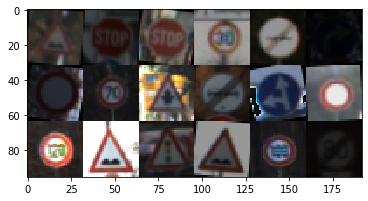

In [4]:
sample_img(data0['x_train'].transpose(0,2,3,1))

# Create a class for building CNN

In [0]:
class cnn:
    '''
    This class is for building Convolution Nural Networks.
    Parameters:
        data(numpy array)- Training data
        label(numpy array or list)- Labels for training data
        categories(optional list)- Categories matching the order of label indexing.
        reset(bool defaults to true)- Whether to reset TF default graph or not.
        rescale(bool defaults to true)- Whether to rescale data to range [0,1] or not, when the data is not in range of [0,1].
        image(str defaults to gray)- gray or rbg
        use_batch_norm(bool defaults to true)- Whether to use batch normalization or not. If used input data won't be rescaled even with rescale is true.
        offset(optional float)- Used for batch normalization.
        scale(optional float)- Used for batch normalization.
        epsilon(optional float defaults to 0.001)- Used for batch normalization.
        test(float or int)- Indicate how much data to be used for testing. If integer is given, the imput number of data will be used for testing. 
                            If float(must be in [0,1)) is given, portion of the data will be used for testing.
        val(float or int)- Indicate how much data to be used for validation.
    '''
    def __init__(self,data,label,categories=None,reset=1==1,rescale=1==1,image='gray',use_batch_norm=1==1,offset=None,scale=None,epsilon=.001,test=.2,val=.1):
        self.batch_norm_par=dict()
        self.switch=1==1
        tf.compat.v1.disable_eager_execution()
        self.batch_norm_par['offset']=offset
        self.batch_norm_par['scale']=scale
        self.batch_norm_par['epsilon']=epsilon
        self.rescale=rescale
        self.batch_norm=use_batch_norm
        self.training=tf.compat.v1.placeholder(tf.bool,[1],name='training')
        if image=='gray': self.chanel=1
        elif image=='rbg': self.chanel=3
        data=self.preprocess(data)
        if reset: tf.compat.v1.reset_default_graph()
        raw_x_shape=list(data.shape)
        if image=='gray':
            if len(raw_x_shape)==3:
                pixels=raw_x_shape[-1]*raw_x_shape[-2]
            else:
                pixels=raw_x_shape[-1]
        elif image=='rbg':
            if len(raw_x_shape)==3:
                pixels=raw_x_shape[-2]
            else:
                pixels=raw_x_shape[-2]*raw_x_shape[-3]
        raw_x_shape[0]=None
        label=self.preprocess(label,1==1)
        if categories is not None:self.categories=categories
        self.data=self.split(data,label,test,val)
        self.classes=len(self.data['ytr'][0])
        self.x_raw=tf.compat.v1.placeholder(tf.float32,raw_x_shape,name='x_raw')
        self.y=tf.compat.v1.placeholder(tf.float32,[None,self.classes],name='y')
        if (image=='gray' and len(self.x_raw.shape)==2) or (image=='rbg' and len(self.x_raw.shape)==3):
            self.x=tf.reshape(self.x_raw,shape=[-1,int(pixels**.5),int(pixels**.5),self.chanel],name='x')
        else:self.x=self.x_raw
        self.conv=[]
        self.fc=dict()
        self.switch=1==2
        self.maps=[]

    @staticmethod
    def split(x,y,test,valid):
        '''
        Split data and labels into training, testing, and validation data sets. A dictionary is returned.
        Parameters:
            x(numpy array)- data
            y(numpy array)- labels
            test/valid(int or float in range (0,1))- If int, specified number of data will be used for testing/validation. If float portion of data will be used.
        '''
        rand_idx=random.sample(range(x.shape[0]),x.shape[0])
        x=x[rand_idx];y=y[rand_idx]
        if type(test)==float:
            test=int(x.shape[0]*test//1)
        if type(valid)==float:
            valid=int(x.shape[0]*valid//1)
        data=dict()
        data['xte'],data['xval'],data['xtr']=np.split(x,[test,test+valid])
        data['yte'],data['yval'],data['ytr']=np.split(y,[test,test+valid])
        return data

    def preprocess(self,data,label=1==2):
        '''
        Preprocess data(i.e pixels for images) or labels(i.e name or code for image labels).
        Parameters:
            data(numpy array)- data or labels
            label(bool defaults to false)- Where or not the imput array contains labels or not.
        '''
        if not label:
            if self.chanel==3:
                shape=list(data.shape)
                channel_idx=shape.index(3)
                if shape[-1] != channel_idx:
                    if len(shape)==3:
                        data=data.transpose(0,2,1)
                    elif len(shape)==4:
                        data=data.transpose(0,2,3,1)
            if np.max(data) > 1:
                if self.rescale and not self.batch_norm:return data/255
                else: return data
            else: return data
        else:
            if type(data[0]) not in [list,np.ndarray]:
                data=np.array(data).reshape(-1,1)
                if self.switch:
                    onehot=code(sparse=1==2,categories='auto')
                    label=onehot.fit_transform(data)
                    self.categories=onehot.categories_[0]
                    self.code=onehot
                    return label
                else:
                    return self.code.transform(data)
            else:
                return data
                
    @staticmethod
    def int2list(num):
        if type(num)==int:
            return [num,num]
        else: return num

    def get_list(self,x,arg,n):
        if arg=='kernal_shapes':
            if type(x)==int:
                return [self.int2list(x) for nn in n]
            elif type(x)==list:
                return [self.int2list(s) for s in x]
            elif type(x)==tuple:
                return [list(x) for nn in n]
            else: raise ValueError('Invalid kernal_shapes argument. Please read doc string.')
        elif arg in ['conv_strides','pool_kernals','pool_strides']:
            if type(x)==int:
                return [self.int2list(x) for nn in n]#[[1]+self.int2list(x)+[self.chanel] for nn in n]
            elif type(x)==list:
                return [self.int2list(s) for s in x]#[[1]+self.int2list(s)+[self.chanel] for s in x]
            elif type(x)==tuple:
                return [list(x) for nn in n]#[[1]+list(x)+[self.chanel] for nn in n]
            else: raise ValueError('Invalid conv_strides argument. Please read doc string.')

    @staticmethod
    def activation(fn,input_,alpha,name=None):
        if fn=='relu':
            return tf.nn.relu(input_,name=name)
        elif fn=='elu':
            return tf.nn.elu(input_,name=name)
        elif fn=='sigmoid':
            return tf.nn.sigmoid(input_,name=name)
        elif fn=='leaky_relu':
            return tf.nn.leaky_relu(input_,alpha,name=name)
        elif fn=='selu':
            return tf.nn.selu(input_,name=name)
        elif fn=='tanh':
            return tf.nn.tanh(input_,name=name)

    @staticmethod
    def pool(method,input_,kernal,stride,pad,name=None):
        if method=='max':
            return tf.nn.max_pool2d(input_,kernal,strides=stride,padding=pad,name=name)
        elif method=='avg':
            return tf.nn.avg_pool2d(input_,kernal,strides=stride,padding=pad,name=name)
        else:
            raise ValueError('Unrecognized or unsupported pooling option.')

    def convolution(self,n_maps,conv_strides=1,kernal_shapes=5,pool_kernals=2,pool_strides=2,pads='SAME',act_fns='relu',pools='max',alphas=.2,initializer='Xavier'):
        '''
        This method sets up all convolution + pooling layers at once.
        Parameters:
            n_maps(list of integers)- Specifies the number of feature maps in each convolution layers.
                Example >> nmaps=[32,64] sets up convolution layer 1 with 32 feature maps, and 64 for layer 2.

            conv_strides(int, tuple, or list defaults to 1)- Specifies strides used for convolution operation for each convolution layers.
                Example >> conv_strides=1 use strides 1 by 1 for all convolution operations.
                           conv_strides=(1,2) use strides 1 by 2 for all convolution operations.
                           conv_strides=[1,2,[2,1],3] use strides 1 by 1 for first convolution operation, 2 by 2 for second, 2 by 1 for third, and 3 by 3 for last.
                           conv_strides=[1,2] use strides 1 by 1 for first convolution operation and 2 by 2 for last.

            kernal_shapes(int, tuple, or list defaults to 5)- Specifies filter used for convolution operation for each convolution layers.
            pool_kernals(int, tuple, or list defaults to 2)- Specifies kernal used for pooling operation for each convolution layers.
            pool_strides(int, tuple, or list defaults to 2)- Specifies strides used for pooling operation for each convolution layers.
            pads(str or list of str defaults to SAME with VALID as an alternative)- Padding options to be used for convolution and pooling operations in each layers.
            act_fns(str or list of str defaults to relu with elu, sigmoid, leaky elu, selu, tanh as alternatives)- Activation function to be used for convolution operations in each layers.
            pools(str or list of str defaults to max with avg as an alternative)- Pooling option to be used in each layers.
            alphas(float or list of floats defaults to 0.2)- Alphas to be used if leaky elu activation is used in each layers.
            initializer(str or list of str defaults to Xavier with He as an alternative)- Initializer to be used in each layers.
        '''
        if initializer =='Xavier': initializer=tf.initializers.glorot_normal
        elif initializer =='He': initializer=tf.initializers.he_normal
        else: raise ValueError('Unrecognized or unsupported initializer.')
        kernal_shapes=self.get_list(kernal_shapes,'kernal_shapes',n_maps)
        conv_strides=self.get_list(conv_strides,'conv_strides',n_maps)
        pool_strides=self.get_list(pool_strides,'pool_strides',n_maps)
        pool_kernals=self.get_list(pool_kernals,'pool_kernals',n_maps)
        if type(pads)==str: pads=[pads for n in n_maps]
        if type(act_fns)==str: act_fns=[act_fns for n in n_maps]
        if type(pools)==str: pools=[pools for n in n_maps]
        if type(alphas)!=list: alphas=[alphas for n in n_maps]
        for ks,nm,cs,ps,pd,af,pl,a,pk in zip(kernal_shapes,n_maps,conv_strides,pool_strides,pads,act_fns,pools,alphas,pool_kernals):
            conv=dict()
            conv['maps']=nm;conv['cs']=cs;conv['ps']=ps;conv['pd']=pd;conv['af']=af;conv['pl']=pl;conv['a']=a;conv['pk']=pk
            layer=len(self.conv)+1
            name='conv'+str(layer)+'_'
            if  layer==1:
                img_in=self.x
                kernal_shape=ks+[self.chanel,nm]
                shape=self.x.shape.as_list()
                n_in=shape[1]*shape[2]
            else:
                img_in=self.conv[-1]['pool']
                kernal_shape=ks+[self.conv[-1]['maps']]+[nm]
                shape=self.conv[-1]['pool'].shape.as_list()
                n_in=shape[1]*shape[2]
            if pd not in ['SAME','VALID']: raise ValueError('Unrecognized or unsupported padding option.')
            #std=self.init(n_in,n_in,af)
            #conv['w']=tf.Variable(tf.random.truncated_normal(kernal_shape,stddev=std),name=name+'w')
            conv['w']=tf.compat.v1.get_variable(name+'w',shape=kernal_shape,initializer=initializer())
            #conv['b']=tf.Variable(tf.constant(.1,shape=kernal_shape[-1:]),name=name+'b')
            conv['b']=tf.compat.v1.get_variable(name+'b',shape=kernal_shape[-1:],initializer=initializer())
            conv['conv']=tf.nn.conv2d(img_in,conv['w'],cs,padding=pd,name=name+'conv')+conv['b']
            if self.batch_norm:
                mu,v=tf.nn.moments(conv['conv'],[0,1,2])
                conv['batch_norm']=batch_norm(conv['conv'],mu,v,self.batch_norm_par['offset'],self.batch_norm_par['scale'],self.batch_norm_par['epsilon'])
                conv['act']=self.activation(af,conv['batch_norm'],a,name=name+'act')
            else:conv['act']=self.activation(af,conv['conv'],a,name=name+'act')
            conv['pool']=self.pool(pl,conv['act'],pk,ps,pd,name=name+'pool')
            self.conv+=[conv]

    def fully_connected(self,features,act_fn='relu',alpha=.2,dropout=1==1,initializer='Xavier'):
        '''
        This method sets up the fully connected layer.
        Parameters:
            features(int): Number of features to extract.
            act_fns(str defaults to relu with elu, sigmoid, leaky elu, selu, tanh as alternatives): Activation function
            alpha(float defaults to 0.2)- Alpha to be used if leaky elu activation is used.
            dropout(bool defaults to true)- Whether to perform dropout operation or not.
            initializer(str defaults to Xavier with He as an alternative)- Initializer to be used.
        '''
        if initializer =='Xavier': initializer=tf.initializers.glorot_normal
        elif initializer =='He': initializer=tf.initializers.he_normal
        else: raise ValueError('Unrecognized or unsupported initializer.')
        self.fc['features']=features
        self.fc['temp']=self.conv[-1]['pool']
        self.fc['conv_out_dim2']=int(self.fc['temp'].shape[-3])*int(self.fc['temp'].shape[-2])*int(self.fc['temp'].shape[-1])
        self.fc['fc']=tf.reshape(self.conv[-1]['pool'],[-1,self.fc['conv_out_dim2']],name='fc')
        #self.fc['w1']=tf.Variable(tf.random.truncated_normal([int(self.fc['fc'].shape[1]),features],stddev=self.init(int(self.fc['fc'].shape[-1]),features)),name='fc_w1')
        self.fc['w1']=tf.compat.v1.get_variable('fc_w1',shape=[int(self.fc['fc'].shape[1]),features],initializer=initializer())
        #self.fc['b1']=tf.Variable(tf.constant(.1,shape=[features]),name='fc_b1')
        self.fc['b1']=tf.compat.v1.get_variable('fc_b1',shape=[features],initializer=initializer())
        self.fc['fc1']=tf.matmul(self.fc['fc'],self.fc['w1'],name='fc1')+self.fc['b1']
        self.fc['act_fn']=act_fn
        if self.batch_norm:
            mu,v=tf.nn.moments(self.fc['fc1'],[0,1])
            self.fc['batch_norm']=batch_norm(self.fc['fc1'],mu,v,self.batch_norm_par['offset'],self.batch_norm_par['scale'],self.batch_norm_par['epsilon'])
            self.fc['act']=self.activation(self.fc['act_fn'],self.fc['batch_norm'],alpha,name='fc_act')
        else:self.fc['act']=self.activation(self.fc['act_fn'],self.fc['fc1'],alpha,name='fc_act')
        

        '''if act_fn=='relu':
            self.fc['act']=tf.nn.relu(self.fc['fc1'],name='fc_act')
        elif act_fn=='elu':
            self.fc['act']=tf.nn.elu(self.fc['fc1'],name='fc_act')
        elif act_fn=='sigmoid':
            self.fc['act']=tf.nn.sigmoid(self.fc['fc1'],name='fc_act')
        elif act_fn=='leaky_relu':
            self.fc['act']=tf.nn.leaky_relu(self.fc['fc1'],alpha,name='fc_act')
        elif act_fn=='selu':
            self.fc['act']=tf.nn.selu(self.fc['fc1'],name='fc_act')
        elif act_fn=='tanh':
            self.fc['act']=tf.nn.tanh(self.fc['fc1'],name='fc_act')
        else:
            raise ValueError('Unrecognized or unsupported activation function option.')'''
        if dropout:
            self.keep_prob = tf.compat.v1.placeholder(tf.float32,name='keep_prob')
            self.layer_drop = tf.nn.dropout(self.fc['act'], rate=1-self.keep_prob,name='layer_drop')
        #self.fc['w2']=tf.Variable(tf.random.truncated_normal([features,int(self.y.shape[1])],stddev=.1),name='fc_w2')
        self.fc['w2']=tf.compat.v1.get_variable('fc_w2',shape=[features,int(self.y.shape[1])],initializer=initializer())
        #self.fc['b2']=tf.Variable(tf.constant(.1,shape=[self.classes]),name='fc_b2')
        self.fc['b2']=tf.compat.v1.get_variable('fc_b2',shape=[self.classes],initializer=initializer())
        if dropout:self.fc['logit']=tf.matmul(self.layer_drop,self.fc['w2'],name='logit')+self.fc['b2']
        else:self.fc['logit']=tf.matmul(self.fc['act'],self.fc['w2'],name='logit')+self.fc['b2']
        self.fc['prob']=tf.nn.softmax(self.fc['logit'],name='prob')

    def train(self,iteration=1501,batch_size=64,plot=1==1,drop_rate=.5,lr=1.5e-4,goal=1):
        '''
        Train the CNN
        Parameters:
            iteration(int defaults to 1501)- number of training iterations.
            batch_size(int defaults to 64)- number of training samples periteration.
            plot(bool defaults to true)- Whether or not to visualize the trainging/testing accuracy.
            drop_rate(float defaults to 0.5)- Drop out rate to be used for drop out layer if performing drop out.
            lr(float defaults to 1.5e-4)- Learning rate
            goal(float in range [0,1] defaults to 1.)- Indicate early stopping validation accuracy. If validation accuracy gets bigger than this number, 
                                                       the taining process stops.
        '''
        cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=self.y,logits=self.fc['logit']))
        train_step = tf.compat.v1.train.AdamOptimizer(lr).minimize(cross_entropy)
        self.correct_prediction = tf.equal(tf.argmax(self.fc['logit'], 1), tf.argmax(self.y, 1))
        self.accuracy = tf.reduce_mean(tf.cast(self.correct_prediction, tf.float32))
        self.sess=tf.compat.v1.Session()
        self.sess.run(tf.compat.v1.global_variables_initializer())
        train_accuracy=[];valid_accuracy=[];step=[]
        for i in range(iteration):
            if i > 0 and valid_accuracy[-1]>goal:
                ref={self.x_raw:self.data['xte'], self.y: self.data['yte'], self.keep_prob: 1.0}
                print('Testing accuracy: {}%'.format(self.accuracy.eval(feed_dict=ref,session=self.sess)*100))
                break
            sample_index=random.sample(range(self.data['xtr'].shape[0]),batch_size)
            train_x = self.data['xtr'][sample_index]
            train_y= self.data['ytr'][sample_index]
            ref={self.x_raw:train_x, self.y: train_y, self.keep_prob: 1.0}
            train_acc= self.accuracy.eval(feed_dict=ref,session=self.sess)
            if i%100 == 0:
                ref={self.x_raw:self.data['xval'], self.y: self.data['yval'], self.keep_prob: 1.0}
                valid_accuracy += [self.accuracy.eval(feed_dict=ref,session=self.sess)]
                step+=[i]
                train_accuracy+=[train_acc]
                print("step %d, batch training accuracy %g, validation accuracy %g"%(i, float(train_accuracy[-1]),float(valid_accuracy[-1])))
            ref={self.x_raw: train_x, self.y: train_y, self.keep_prob: 1-drop_rate}
            train_step.run(feed_dict=ref,session=self.sess)
        
        if plot:
            df=pd.DataFrame({'Training Step':step,'Train':train_accuracy,'Validation':valid_accuracy})
            df= df >> gather('key','Accuracy',['Train','Validation'])
            print(ggplot(aes(x='Training Step',y='Accuracy'),data=df)+geom_line(aes(color='key'))+ggtitle('Accuracy plot'))

        if 1==2:
            n_batches = valid_x.shape[0] // batch_size
            cumulative_accuracy = 0.0
            for index in range(n_batches):
                sample_index=random.sample(range(valid_x.shape[0]),batch_size)
                train_x = valid_x[sample_index]
                train_y= valid_y[sample_index]
                ref={self.x_raw: train_x, self.y: train_y, self.keep_prob: 1.0}
                cumulative_accuracy += self.accuracy.eval(feed_dict=ref,session=self.sess)
            print("test accuracy {}".format(cumulative_accuracy / n_batches))

    def predict(self,data,show_percentage=1==2,use_code=1==1):
        '''
        This method predicts the label(s) for given data.
        Returns: Pandas data frame containing prediction percentage(optional) for each lable and prediction label based on highest percentage.
        '''
        data=self.preprocess(data)
        try:
            ref={self.x_raw: data, self.keep_prob: 1.0}
            p=self.fc['prob'].eval(ref,session=self.sess)
        except:
            data=self.preprocess(data)
            ref={self.x_raw: data, self.keep_prob: 1.0}
            p=self.fc['prob'].eval({self.x_raw: data, self.keep_prob: 1.0,self.training:1==2},session=self.sess)
        if not use_code:df= pd.DataFrame(p,columns=self.categories)
        else:df= pd.DataFrame(p)
        label=[self.categories[i] for i in np.argmax(p,1)]
        df=df.applymap(lambda x:str(np.round(x*100,2))+'%')
        df['Prediction']=label
        df.index.name='Index'
        df.columns.name='Label'
        if show_percentage:return df
        return df['Prediction']
    
    @property
    def show_fails(self):
        '''
        Show examples of wrong prediction testing data(images).
        '''
        ref={self.x_raw: self.preprocess(self.data['xte']), self.keep_prob: 1.0}
        p=self.fc['prob'].eval(ref,session=self.sess)
        prediction=tf.argmax(p,axis=1)
        true=tf.argmax(self.data['yte'],axis=1)
        fail_idx=tf.not_equal(prediction,true).eval(session=self.sess)
        sample_img(self.data['xte'][fail_idx])

# Building CNN

step 0, batch training accuracy 0.0234375, validation accuracy 0.0179352
step 100, batch training accuracy 0.53125, validation accuracy 0.512072
step 200, batch training accuracy 0.875, validation accuracy 0.861232
step 300, batch training accuracy 0.875, validation accuracy 0.933778
step 400, batch training accuracy 0.984375, validation accuracy 0.958611
step 500, batch training accuracy 0.992188, validation accuracy 0.963785
step 600, batch training accuracy 0.976562, validation accuracy 0.975971
step 700, batch training accuracy 0.976562, validation accuracy 0.977581
step 800, batch training accuracy 0.96875, validation accuracy 0.978961
step 900, batch training accuracy 1, validation accuracy 0.980455
step 1000, batch training accuracy 0.96875, validation accuracy 0.97988
step 1100, batch training accuracy 0.976562, validation accuracy 0.985284
step 1200, batch training accuracy 0.976562, validation accuracy 0.983789
step 1300, batch training accuracy 0.992188, validation accuracy 

/usr/local/lib/python3.6/dist-packages/plotnine/scales/scale.py:93: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cbook.iterable(self.breaks) and cbook.iterable(self.labels):
/usr/local/lib/python3.6/dist-packages/plotnine/utils.py:553: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  return cbook.iterable(var) and not is_string(var)


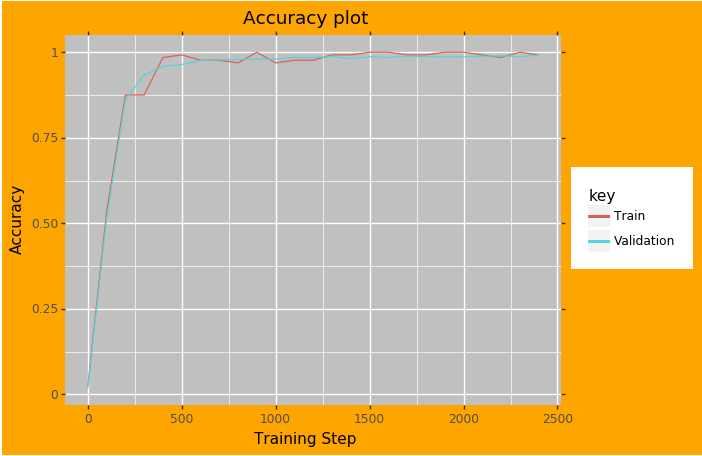

<ggplot: (8770175838377)>


In [29]:
t=cnn(data=data0['x_train'],label=data0['y_train'],image='rbg',use_batch_norm=1==1,categories=data0['labels'])
t.convolution([32,64],kernal_shapes=3,initializer='Xavier',act_fns='relu')
t.fully_connected(1024)
t.train(iteration=3001,batch_size=128,drop_rate=.5,plot=1==1,lr=1.5e-3,goal=.99)

# Example of making prediction

In [9]:
t.predict(t.data['xte'][:5],show_percentage=1==1,use_code=1==1).iloc[:,-5:]

Label,39,40,41,42,Prediction
Index,,,,,
0,0.0%,0.0%,0.0%,0.0%,Speed limit (20km/h)
1,0.0%,0.0%,0.0%,0.0%,Speed limit (30km/h)
2,0.0%,0.0%,100.0%,0.0%,End of no passing
3,100.0%,0.0%,0.0%,0.0%,Keep left
4,0.12%,99.76%,0.07%,0.0%,Roundabout mandatory


# Examples of wrong prediction images

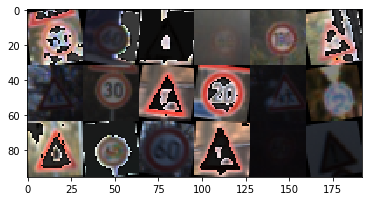

In [31]:
t.show_fails